In [1]:
import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

In [2]:
games = pd.read_csv('./data/games.csv')
GAME1 = games.iloc[0].gameId

In [3]:
plays = pd.read_csv('./data/plays.csv')
plays = plays[plays['gameId'] == GAME1]
PLAY1 = plays.iloc[0].playId

In [4]:
week1 = pd.read_csv('./data/week1.csv')
wgp1 = week1.loc[(week1['gameId'] == GAME1) & (week1['playId'] == PLAY1) & (np.invert(week1.position.isin(['QB', 'LB', 'MLB']))) & (week1['team'] != 'football')]
wgp1

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
5,2018-09-07T01:07:14.599Z,73.64,28.70,0.03,0.02,0.01,103.05,219.41,None,2534832.0,Rodney McLeod,23.0,FS,1,home,2018090600,75,left,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,2018-09-07T01:07:20.400Z,87.30,31.39,2.21,2.11,0.23,326.03,289.29,None,2543583.0,Devonta Freeman,24.0,RB,59,away,2018090600,75,left,NaN
820,2018-09-07T01:07:20.400Z,75.33,12.57,2.55,4.00,0.27,305.76,227.43,None,2552689.0,Ronald Darby,21.0,CB,59,home,2018090600,75,left,NaN
821,2018-09-07T01:07:20.400Z,76.75,52.42,3.86,3.56,0.39,55.22,22.42,None,2555383.0,Jalen Mills,31.0,CB,59,home,2018090600,75,left,NaN
822,2018-09-07T01:07:20.400Z,77.41,9.59,3.44,5.45,0.38,96.53,182.50,None,2555415.0,Austin Hooper,81.0,TE,59,away,2018090600,75,left,OUT


In [5]:
pd.unique(wgp1.event)

array(['None', 'ball_snap', 'pass_forward', 'pass_arrived',
       'pass_outcome_caught', 'out_of_bounds'], dtype=object)

In [6]:
time1 = wgp1[wgp1['event'] == 'ball_snap'].time.iloc[0]
time2 = wgp1[wgp1['event'] == 'pass_forward'].time.iloc[0]
wgp1_tf = wgp1.loc[(wgp1['time'] >= time1) & (wgp1['time'] <= time2)]

In [7]:
ball_snap = wgp1_tf[wgp1_tf['event'] == 'ball_snap']
offense = []
defense = []
for i,r in ball_snap.iterrows():
    tup = (r.nflId, r.x, r.y)
    if r.team == 'away':
        offense.append(tup)
    else:
        defense.append(tup)
prod = list((it.product(offense, defense)))
distances = [(wr[0], cb[0], np.linalg.norm(np.subtract([wr[1], wr[2]], [cb[1], cb[2]]))) for wr, cb in prod]
distances = sorted(distances, key=lambda t: t[2])


In [8]:
pairs = []
while(len(pairs) < len(offense)):
    closest = distances[0]
    pairs.append(closest)
    distances = list(filter(lambda d: (d[0] != closest[0]) and (d[1] != closest[1]), distances[1:]))
pairs

[(2533040.0, 79848.0, 1.9203385118254552),
 (2555415.0, 2495613.0, 4.833352873523718),
 (2495454.0, 2555383.0, 7.472857552502922),
 (2559033.0, 2552689.0, 13.944177996569042),
 (2543583.0, 2534832.0, 24.727636360962606)]

In [9]:
players = pd.read_csv('./data/players.csv')
p1 = players[players['nflId'] == 2533040].iloc[0].displayName
def mapIdsToName(tup):
    p1 = players[players['nflId'] == tup[0]].iloc[0].displayName
    p2 = players[players['nflId'] == tup[1]].iloc[0].displayName
    return (p1, p2)

In [10]:
list(map(mapIdsToName, pairs))

[('Mohamed Sanu', 'Malcolm Jenkins'),
 ('Austin Hooper', 'Corey Graham'),
 ('Julio Jones', 'Jalen Mills'),
 ('Ricky Ortiz', 'Ronald Darby'),
 ('Devonta Freeman', 'Rodney McLeod')]

In [11]:
times = pd.unique(wgp1_tf.time)
pairs = pairs[:3]
distance = []
predictor = []
current_pos = 0
for p in pairs:
    starting_distance = -1
    classification = 0
    for t in times:
        frame = wgp1_tf[wgp1_tf['time'] == t]
        receiver = frame[frame['nflId'] == p[0]]
        defender = frame[frame['nflId'] == p[1]]
        xdif = np.abs(receiver.x.values[0] - defender.x.values[0])
        ydif = np.abs(receiver.y.values[0] - defender.y.values[0])
        dist = np.linalg.norm((xdif, ydif))
        
        if starting_distance < 0:
            starting_distance = dist
        
        if np.abs(dist - starting_distance > 5):
            classification = 1
            break
            
    predictor.append(classification)



In [12]:
if stats.mode(predictor)[0][0] == 0:
    play_type = 'man'
else:
    play_type = 'zone'
print(play_type)

man


(0, 10)

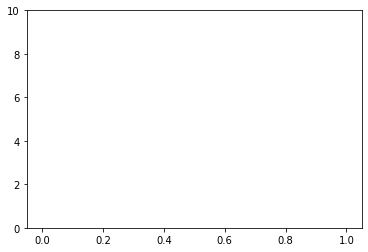

In [13]:
xs = np.arange(len(distance))
plt.plot(xs, distance)
plt.ylim([0, 10])

In [14]:
from collections import defaultdict
pairs = pairs[:3]
pTp = [p[0] for p in pairs]
pTp += [p[1] for p in pairs]
playerpositions = defaultdict(lambda: defaultdict(list))
for t in times:
    frame = wgp1_tf[wgp1_tf['time'] == t]
    for p in pTp:
        player = frame[frame['nflId'] == p]
        x = player.x.values[0]
        y = player.y.values[0]
        playerpositions[p]['x'].append(x)
        playerpositions[p]['y'].append(y)
        playerpositions[p]['team'] = player.team.values[0]

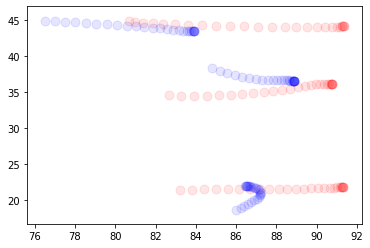

In [15]:
offense = True
for _id, vals in playerpositions.items():
    if vals['team'] == 'away': 
        color = 'red'
    else: 
        color = 'blue'
    plt.scatter(vals['x'], vals['y'], c=color, alpha=.1, s=80)
    offense = not offense